# Learning outcomes
1. Gentle intro on CV
2. Recap on images as Numpy array
3. Image cropping
4. Splitting and merging of color channels
5. Point operators 
    - elementary operations: addition, subtraction, multiplication and division
    - gamma correction (nonlinear technique)
6. Image blending (add 2 images together)

## Setup


In [2]:
import sys
assert sys.version_info >= (3, 7)

import cv2 as cv
import numpy as np
from util_func import show_img


## Recap on images as Numpy array
There are 2 types of images: **grayscale** and **color**

| grayscale | color |
| :-: | :-: |
| matrix (2D array) | 3D array |
| (h, w) | (h, w, channels) |


In [17]:
# Create a graysclae image
img = np.zeros((2, 4), dtype = np.uint8)
print(img.shape)
print(img)

(2, 4)
[[0 0 0 0]
 [0 0 0 0]]


In [8]:
img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

print(img_color.shape)
print(img_color)

(2, 4, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [9]:
img[0, 1] = 50
img[1, 2] = 150

print(img)

[[  0  50   0   0]
 [  0   0 150   0]]


In [10]:
img_color = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

print(img_color)

[[[  0   0   0]
  [ 50  50  50]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [150 150 150]
  [  0   0   0]]]


### Access elements in array

In [11]:
img = cv.imread("images/lena.jfif")

a = img[49, 219, 2]
b = img.item(49, 219, 2)

a == b

True

In [12]:
%timeit a = img[49, 219, 2]
%timeit b = img.item(49, 219, 2)

119 ns ± 5.12 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
119 ns ± 9.17 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Numpy slicing

In [19]:
# top left patch of the img

h, w = img.shape[:2]
yc, xc = h // 2, w // 2#center y, center x

topleft = img[:yc, :xc]

show_img("topleft", topleft)

In [29]:
# 60x60 central region of the img
centre = img[yc-30:yc+30, xc-30:xc+30]

show_img("centre", centre)


### Create a white image

In [30]:
img = np.zeros((200, 200)) + 255
img = np.uint8(img)

show_img("img", img)

### Exercise

In [45]:
## Extract region of interest
img = cv.imread("images/flower.jfif")

show_img("img", img)

### There are three ways to get the indices needed.

In [34]:
[i for i in dir(cv) if i.startswith("EVENT")]

['EVENT_FLAG_ALTKEY',
 'EVENT_FLAG_CTRLKEY',
 'EVENT_FLAG_LBUTTON',
 'EVENT_FLAG_MBUTTON',
 'EVENT_FLAG_RBUTTON',
 'EVENT_FLAG_SHIFTKEY',
 'EVENT_LBUTTONDBLCLK',
 'EVENT_LBUTTONDOWN',
 'EVENT_LBUTTONUP',
 'EVENT_MBUTTONDBLCLK',
 'EVENT_MBUTTONDOWN',
 'EVENT_MBUTTONUP',
 'EVENT_MOUSEHWHEEL',
 'EVENT_MOUSEMOVE',
 'EVENT_MOUSEWHEEL',
 'EVENT_RBUTTONDBLCLK',
 'EVENT_RBUTTONDOWN',
 'EVENT_RBUTTONUP']

In [46]:
# 1 way
img = cv.imread("images/flower.jfif")
img_copy = img.copy()

def rect_region(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print((x,y))
        cv.circle(img, (x,y), 1, (0, 0, 255), -1) #-1 = fill circle
        cv.imshow("img", img)
        
cv.imshow("img", img)
cv.setMouseCallback("img", rect_region)
cv.waitKey(0)
cv.destroyAllWindows()

(83, 20)
(128, 115)


In [47]:
flower = img_copy[41:120, 89:173]

show_img("flower", flower)

In [49]:
# 2nd way
bbox = cv.selectROI("crop", img_copy)

flower = img_copy[int(bbox[1]): int(bbox[1] + bbox[3]),
                  int(bbox[0]): int(bbox[0] + bbox[2])] #y1 =y1 + h, x1 = x1 + h

show_img("flower", flower)

In [50]:
#3rd way, get x and y using paint app

In [64]:
img_arr = np.zeros((30,30), dtype = np.uint8)
img_arr[:10,10:20] = 255 #:10 = 0:10
img_arr[10:20, 0:10] = 255
img_arr[10:20, 20:] = 255
img_arr[20:, 10:20] = 255

img = np.tile(img_arr, (3,3)) #repeat the patch 3x3

show_img("pattern", img)

## Image cropping
Why?
- Remove unwanted object
- Separate the image into a $3 \times 3$ grids. We move / adjust the camera in such a way that the object of interest lies on the gridlines or their intersections. As such, your image would look more aesthetically appealing. This is known as rule of thirds.
- One of the image augmentation methods for deep learning model training.

In [38]:
img = cv.imread("images/dog.jfif")
img_copy = img.copy()

h, w = img.shape[:2]

#user defined parameters
n_vertical_grids = 4
n_horizontal_grids = 4

M = int(h / n_vertical_grids)
N = int(w / n_horizontal_grids)

tiles = []

for y in range(0, h, M): #adjust x,y if exceed the img boundary
    for x in range(0, w, N):
        x1 = x + N
        y1 = y + M
        
        if x1 > w and y1 > h:
            x1 = w - 1
            y1 = h - 1
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1) 
            tile = img[y:h, x:w]
            tiles.append(tile)
            
        elif y1 > h:
            y1 = h - 1
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
            tile = img[y:h, x:x1]
            tiles.append(tile)
            
        elif x1 > w:
            x1 = w - 1
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
            tile = img[y:y1, x:w]
            tiles.append(tile)
            
        else:
            cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)
            tile = img[y:y1, x:x1]
            tiles.append(tile)
            
show_img("crop", img_copy)
        

In [73]:
show_img("patch", tiles[9])

## Splitting and merging color channels


In [75]:
img = cv.imread("images/lena.jfif")

(b, g, r) = cv.split(img)
img_merge = cv.merge((b, g, r))
np.array_equal(img, img_merge)

True

In [77]:
import matplotlib.pyplot as plt

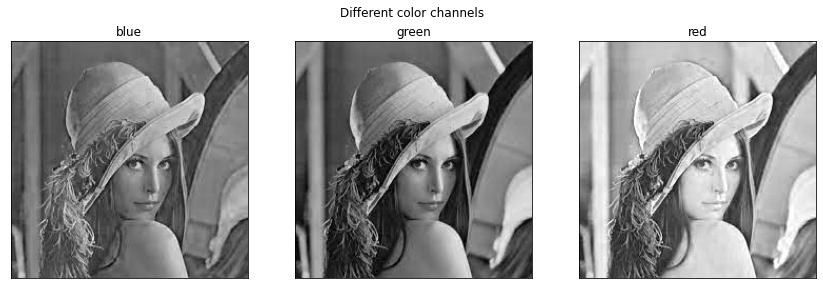

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4), sharey = True) #1,3 -> 1 row 3 columns
fig.suptitle("Different color channels")

ax1.imshow(b, cmap=plt.cm.gray)
ax1.set(title = "blue", xticks = [], yticks=[]) #dun want have xticks, yticks
ax2.imshow(g, cmap=plt.cm.gray)
ax2.set(title = "green", xticks = [], yticks=[]) #dun want have xticks, yticks
ax3.imshow(r, cmap=plt.cm.gray)
ax3.set(title = "red", xticks = [], yticks=[]) #dun want have xticks, yticks

plt.tight_layout() #make sure the img is fitted
plt.show()

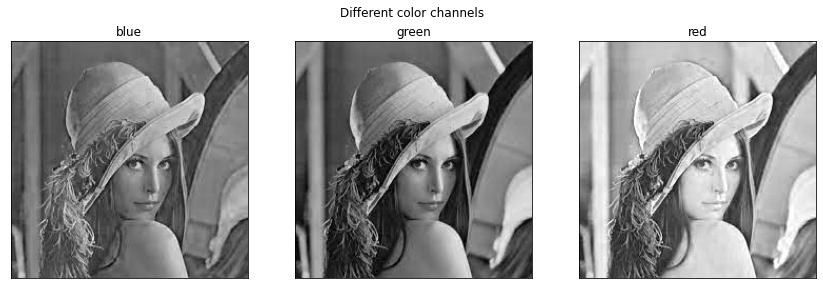

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4), sharey = True) #1,3 -> 1 row 3 columns
fig.suptitle("Different color channels")

ax1.imshow(b, cmap=plt.cm.gray)
ax1.set(title = "blue", xticks = [], yticks=[]) #dun want have xticks, yticks
ax2.imshow(g, cmap=plt.cm.gray)
ax2.set(title = "green", xticks = [], yticks=[]) #dun want have xticks, yticks
ax3.imshow(r, cmap=plt.cm.gray)
ax3.set(title = "red", xticks = [], yticks=[]) #dun want have xticks, yticks

plt.tight_layout() #make sure the img is fitted
plt.show()

### Display different channels in color images

In [95]:
img = cv.imread("images/dog.jfif")

channels = cv.split(img)
#this color variable will be window names
colors = ("blue", "green", "red")

imgs = []

for i, ch in enumerate(channels):
    img_arr = np.zeros_like(img)
    #img_arr[:, :, i] = ch
    img_arr[...,i] = ch
    imgs.append(img_arr)
    
for c, img in zip(colors, imgs):
    cv.imshow(c, img)
    
cv.waitKey(0)
cv.destroyAllWindows()

## Point operators
Elementary math operations: addition, subtraction, multiplication, and division.

$$f_{trans}(\textbf{x}) = \alpha f(\textbf{x}) + \beta $$

- $$\alpha > 1, high contrast $$
- $$0 < \alpha < 1, low contrast $$
- $$\beta > 0, high brightness $$
- $$\beta < 0, low brightness $$

In [96]:
np.uint8(np.array([-2, 0, 255, 300])) #uint8 is 0 to 255, -2 = 254

array([254,   0, 255,  44], dtype=uint8)

In [99]:
def point_op(img, alpha, beta):
    """point operators of image. Arguments:
    1. source image
    2. multiplier
    3. constant"""
    
    img = img.astype(float) #cannot +-x/ uint 8, so convert to float
    res = alpha * img + beta
    res = np.clip(res, 0, 255)
    return np.uint8(res)

In [100]:
img = cv.imread("images/bridge.jfif")

#increase the brightness and contrast
transform = point_op(img, 1.6, 20)

cv.imshow("original", img)
show_img("transform", transform)

In [101]:
darken = point_op(img, 1, -80)

show_img("img", darken)

## gamma correction
Technique to adjust brightness of image.

$$O = (\frac{I}{255})^{\gamma} \times 255$$

In [102]:
gamma = 1 / 2.2 #gamma < 1 will brighten the dark area

lookUpTable = np.empty((1, 256), dtype = np.uint8)

for i in range(256):
    lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    
img = cv.imread("images/mountains_prop.jpg")
res = cv.LUT(img, lookUpTable)

cv.namedWindow("original", cv.WINDOW_NORMAL)
cv.imshow("original", img)
show_img("gamma correction", res, adjust = True)

## Image blending (add 2 images)
```
cv.addWeighted(img1, alpha, img2, 1-alpha, beta)
```

$$h(\textbf{x}) = \alpha f(\textbf{x}) + (1 - \alpha)g(\textbf{x}) + \beta$$

f(x) = img1, g(x) = img2

In [6]:
img = cv.imread("images/lena.jfif")
img2 = cv.imread("images/coins.jfif")

# resize img2 to be the same dimension as img
h, w = img.shape[:2]
img2 = cv.resize(img2, (w, h))
alpha = 0.7

res = cv.addWeighted(img, alpha, img2, 1-alpha, 0)

cv.imshow("lena", img)
cv.imshow("resized coin", img2)
show_img("image blending", res)

## Exercise

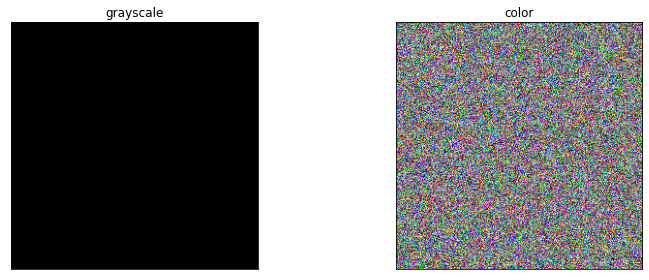

In [46]:
# Ex 1
import matplotlib.pyplot as plt

width = 255
height = 255

# Create a graysclae image
grayscale_img = np.zeros((width, height), dtype = np.uint8)

#create a random noise color image
color_img = np.random.randint(256, size = (width,height,3), dtype = np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4), sharey = True) #1,3 -> 1 row 3 columns

ax1.imshow(grayscale_img, cmap=plt.cm.gray)
ax1.set(title = "grayscale", xticks = [], yticks=[]) #dun want have xticks, yticks
ax2.imshow(color_img)
ax2.set(title = "color", xticks = [], yticks=[]) #dun want have xticks, yticks

plt.tight_layout() #make sure the img is fitted
plt.show()

In [45]:
# Ex 2
def crop_grid(img, num_horizontal_grid, num_vertical_grid, line_color):
    img_copy = img.copy()

    height, width = img.shape[:2]

    # M and N are basically number of pixels per patch
    M, N = int(height / num_vertical_grid), int(width / num_horizontal_grid)

    x1, y1 = 0, 0

    for y in range(0, height, M):
        for x in range(0, width, N):

            y1 = y + M
            x1 = x + N

            if x1>=width and y1>=height:
                x1 = width-1
                y1 = height-1
                tile = img[y:height, x:width]
                cv.rectangle(img_copy, (x,y), (x1, y1), (0, 255, 0), 1)
                cv.imshow('tile', tile)

            elif y1>=height:
                y1 = height-1
                cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)

            elif x1>=width:
                x1 = width-1
                cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)

            else:
                cv.rectangle(img_copy, (x, y), (x1, y1), (0, 255, 0), 1)

    cv.imshow('patched image', img_copy)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [18]:
# Ex 3
img = cv.imread("images/lena.jfif")
img2 = cv.imread("images/coins.jfif")

# resize img2 to be the same dimension as img
h, w = img.shape[:2]
img2 = cv.resize(img2, (w, h))

for i in range (11):
    alpha = i/10
    res = cv.addWeighted(img, alpha, img2, 1-alpha, 0)
    show_img("image blending", res)

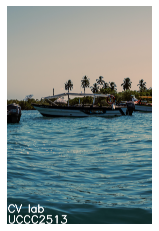

In [140]:
# Ex 4
import matplotlib.pyplot as plt

img = cv.imread("images/travel_hd.jpg")

text = ['UCCC2513', 'CV lab'] #index 0 will be placed at bottom

font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 10
color = (255,255,255) #white
thickness = 30
lineType = cv.LINE_AA
bottomLeftOrigin = False


offset = (int(h/len(text)) - 10) * len(text) #bottom left of pict

for itr, word in enumerate(text):
    cv.putText(img,
               word, 
               (20,offset),
               font,
               fontScale,
               color,
               thickness,
               lineType,
               bottomLeftOrigin)
    offset -= fontScale * 30


cv.namedWindow("img", cv.WINDOW_NORMAL)
cv.imshow("img", img)
show_img("img", img)

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()